In [5]:
# =============================
# Imports
# =============================
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc as compute_auc
)
import yaml

# Add ../src to sys.path so we can import models
PROJECT_ROOT = Path("../src").resolve()
sys.path.append(str(PROJECT_ROOT))

from models import LeNetVariant  # now this should work

In [6]:
# =============================
# Paths & Directories
# =============================
PROJECT_ROOT = Path("..").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts/inference"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

X_TEST_PATH = PROJECT_ROOT / "data/processed/X_test.npy"
Y_TEST_PATH = PROJECT_ROOT / "data/processed/Y_test.npy"

CHECKPOINTS = {
    "lenet_avgpool": PROJECT_ROOT / "model/lenet_avgpool/best_model.pt",
    "lenet_maxpool": PROJECT_ROOT / "model/lenet_maxpool/best_model.pt",
    "lenet_strided": PROJECT_ROOT / "model/lenet_strided/best_model.pt"
}

CONFIGS = {
    "lenet_avgpool": PROJECT_ROOT / "configs/model_lenet_avgpool.yaml",
    "lenet_maxpool": PROJECT_ROOT / "configs/model_lenet_maxpool.yaml",
    "lenet_strided": PROJECT_ROOT / "configs/model_lenet_strided.yaml"
}

In [7]:
# =============================
# Utilities
# =============================
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

def save_plot(fig, filename):
    path = ARTIFACTS_DIR / filename
    fig.savefig(path, bbox_inches="tight", dpi=150)
    print(f"Saved plot: {path}")

def evaluate(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        auc_score = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc_score = float('nan')
    print(f"{model_name} | Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC AUC: {auc_score:.4f}")
    return acc, f1, auc_score

In [8]:
# =============================
# Load Test Data
# =============================
X_test = np.load(X_TEST_PATH)
y_test = np.load(Y_TEST_PATH)

# If X_test shape is (N, H, W), we need to add channel dimension
if X_test.ndim == 3:
    X_test = np.expand_dims(X_test, axis=1)  # shape becomes (N, 1, H, W)
elif X_test.ndim == 4:
    # already has channel dimension
    pass
else:
    raise ValueError(f"Unexpected X_test shape: {X_test.shape}")

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
# =============================

In [10]:
# =============================
# Inference & Side-by-Side Plots
# =============================
results = []

for model_name, ckpt_path in CHECKPOINTS.items():
    config_path = CONFIGS[model_name]

    model = LeNetVariant(config_path=config_path)
    model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
    model.to('cpu')
    model.eval()

    with torch.no_grad():
        outputs = model(X_test)
        probs = torch.sigmoid(outputs).squeeze()  # shape: [batch_size]
        preds = (probs >= 0.5).long()  # threshold at 0.5

    y_true_np = y_test.cpu().numpy()
    y_pred_np = preds.cpu().numpy()
    y_probs_np = probs.cpu().numpy()

    acc, f1, auc_score = evaluate(y_true_np, y_pred_np, model_name)
    
    results.append({
        "model": model_name,
        "accuracy": acc,
        "f1_score": f1,
        "roc_auc": auc_score,
        "y_true": y_true_np,
        "y_pred": y_pred_np,
        "y_prob": y_probs_np
    })

lenet_avgpool | Accuracy: 0.8750 | F1: 0.8889 | ROC AUC: 0.8750
lenet_maxpool | Accuracy: 0.9375 | F1: 0.9412 | ROC AUC: 0.9375
lenet_strided | Accuracy: 1.0000 | F1: 1.0000 | ROC AUC: 1.0000


Saved plot: C:\Users\Kapil IT Skill HUB\Desktop\DownScaleXR\artifacts\inference\lenet_avgpool_side_by_side.png


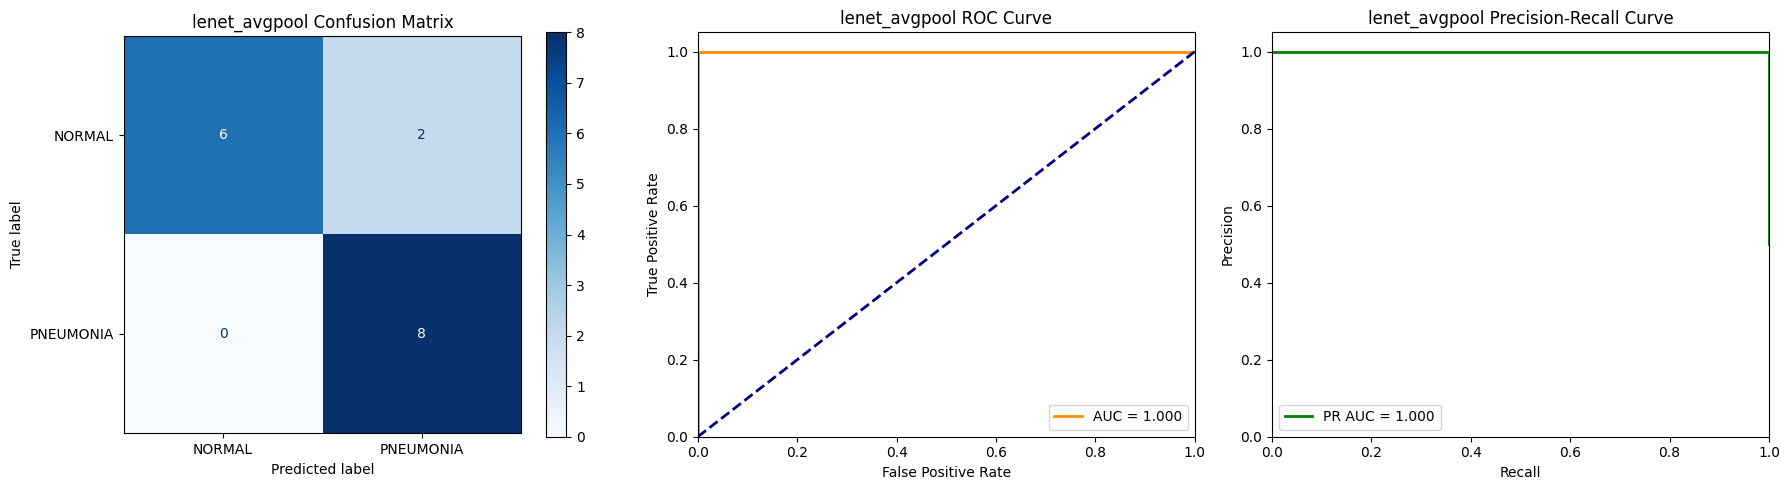

Saved plot: C:\Users\Kapil IT Skill HUB\Desktop\DownScaleXR\artifacts\inference\lenet_maxpool_side_by_side.png


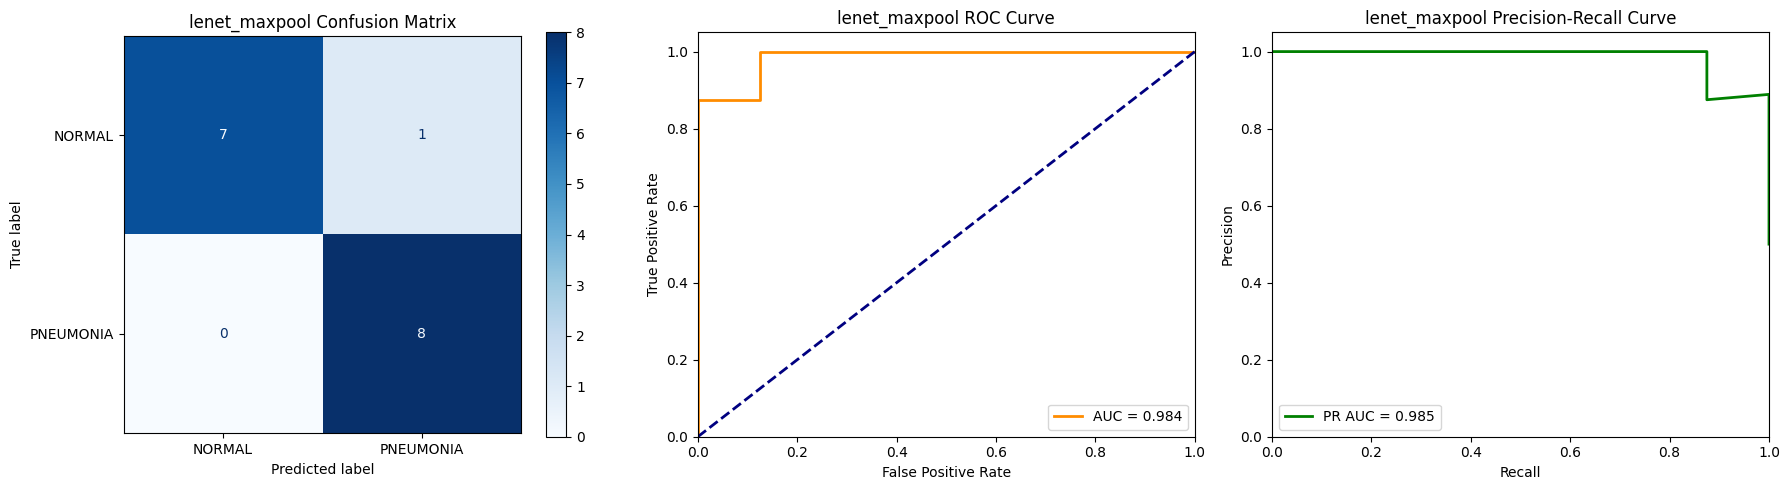

Saved plot: C:\Users\Kapil IT Skill HUB\Desktop\DownScaleXR\artifacts\inference\lenet_strided_side_by_side.png


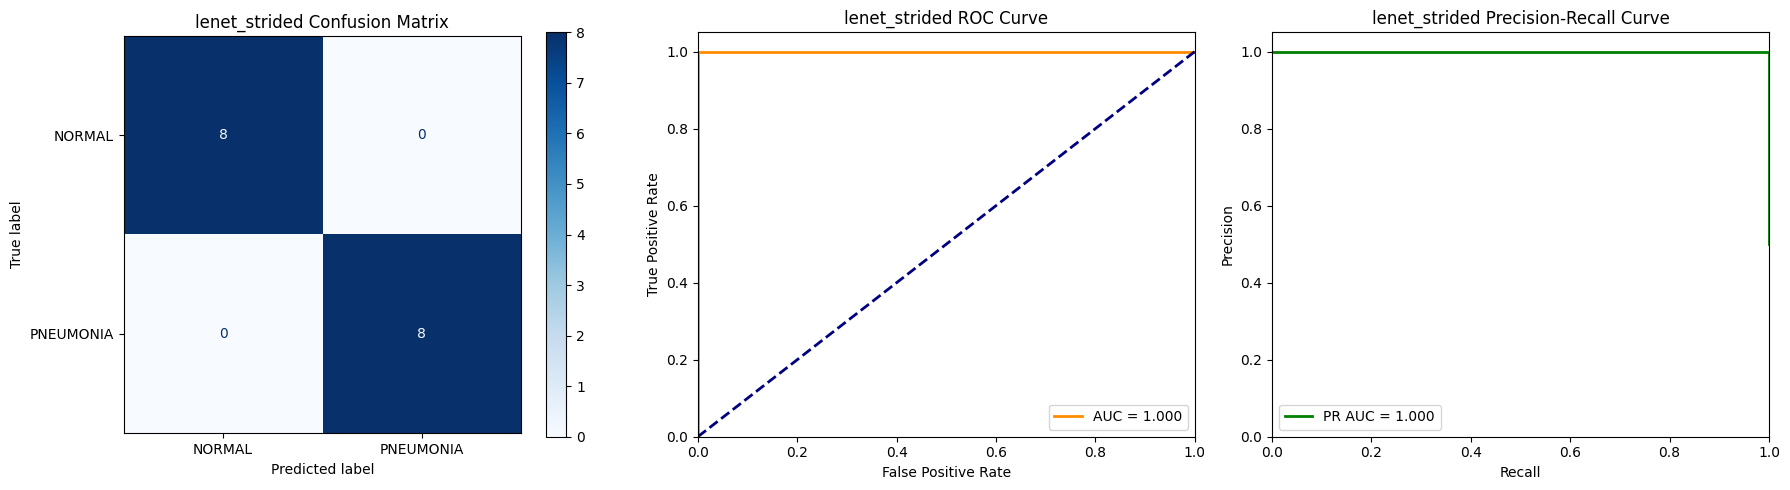

In [11]:
# =============================
# Plot Side-by-Side for Each Model
# =============================
for r in results:
    model_name = r["model"]
    y_true, y_pred, y_prob = r["y_true"], r["y_pred"], r["y_prob"]
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["NORMAL", "PNEUMONIA"])
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = compute_auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = compute_auc(recall, precision)
    
    # Side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    
    # Confusion Matrix
    disp.plot(ax=axes[0], cmap="Blues", values_format="d")
    axes[0].set_title(f"{model_name} Confusion Matrix")
    
    # ROC Curve
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange', lw=2)
    axes[1].plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0,1])
    axes[1].set_ylim([0,1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"{model_name} ROC Curve")
    axes[1].legend(loc="lower right")
    
    # Precision-Recall Curve
    axes[2].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}", color='green', lw=2)
    axes[2].set_xlim([0,1])
    axes[2].set_ylim([0,1.05])
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title(f"{model_name} Precision-Recall Curve")
    axes[2].legend(loc="lower left")
    
    plt.tight_layout()
    save_plot(fig, f"{model_name}_side_by_side.png")
    plt.show()
    plt.close(fig)

Saved plot: C:\Users\Kapil IT Skill HUB\Desktop\DownScaleXR\artifacts\inference\model_comparison.png


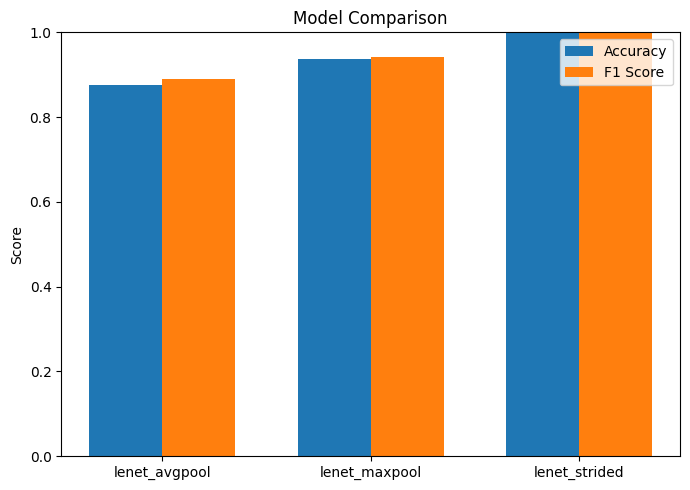

In [12]:
# =============================
# Comparison Bar Plot
# =============================
fig, ax = plt.subplots(figsize=(7,5))
model_names = [r["model"] for r in results]
accuracies = [r["accuracy"] for r in results]
f1_scores = [r["f1_score"] for r in results]
x = np.arange(len(model_names))
width = 0.35
ax.bar(x - width/2, accuracies, width, label='Accuracy')
ax.bar(x + width/2, f1_scores, width, label='F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim([0,1])
ax.set_ylabel("Score")
ax.set_title("Model Comparison")
ax.legend()
plt.tight_layout()
save_plot(fig, "model_comparison.png")
plt.show()
plt.close(fig)
